In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import itertools
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import multiprocessing
from CustomFunctions import PCvisualization, DetailedBalance



def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)


#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [34]:
#get directories and open separated datasets

time_interval = 5 #sec/frame

datadir = 'E:/Aaron/random_lls/'
savedir = datadir + 'random/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

TotalFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

nbins = np.max(TotalFrame[[x for x in TotalFrame.columns.to_list() if 'bin' in x]].to_numpy())


#limit data to the Para-Nitro-Blebbistatin experiments
TotalFrame = FullFrame[FullFrame.Experiment == 'Drug']
dates = [20240624,20240626,20240701]
TotalFrame = TotalFrame[TotalFrame.Date.isin(dates)]
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=['DMSO','Para-Nitro-Blebbistatin'], ordered=True)

In [35]:
########### interpolate all transitions so that only individual transitions are made ###########

if (os.path.exists(savedir+'interpolated_PC2-PC7_transitions.csv')) & (os.path.exists(savedir+'interpolated_PC2-PC7_transition_pairs.csv')):
        
    transdf = pd.read_csv(savedir+'interpolated_PC2-PC7_transitions.csv')
    transpairsdf = pd.read_csv(savedir+'interpolated_PC2-PC7_transition_pairs.csv')
    print('Opened transition files')
    
else:

    if __name__ ==  '__main__':
        pool = multiprocessing.Pool(processes=60)
        results = []
        for i, cells in TotalFrame.groupby('CellID'):
            cells = cells.sort_values('time').reset_index(drop = True)
            diff = cells.time.diff()
            difflist = [0]
            difflist.extend(diff[diff>5].index.to_list())
            runs = []
            for x in range(len(difflist)-1):
                runs.append(list(range(difflist[x], difflist[x+1])))

            for r in runs:
                r = np.array(r, dtype=int)
                #skip runs less than 3 frames long
                if len(r)<2:
                    pass
                else:
                    cell = cells.iloc[r]

                    pool.apply_async(DetailedBalance.interpolate_2dtrajectory, args = (
                        time_interval,
                        cell.CellID.iloc[0],
                        cell.frame.to_list(),
                        cell[['PC2bins','PC7bins']].to_numpy(),
                        ),
                        callback = collect_results)
    pool.close()
    pool.join()


    transdf = pd.DataFrame(sum([r[0] for r in results],[]))
    transdf = transdf.sort_values(by = ['CellID','frame']).reset_index(drop=True)
    transpairsdf = pd.DataFrame(sum([r[1] for r in results],[]))
    transdf.to_csv(savedir+'interpolated_PC2-PC7_transitions.csv')
    transpairsdf.to_csv(savedir+'interpolated_PC2-PC7_transition_pairs.csv')

    print('Calculated transitions')
    
    
    
############## get the counts of cells leaving 

if os.path.exists(savedir+'PC2-PC7_binned_transition_rates.csv'):
    trans_rate_df = pd.read_csv(savedir+'PC2-PC7_binned_transition_rates.csv')
    print('Opened transition rate files')
else:
    
    #calculate the total time observed during the experiment
    ttot = transdf.time_elapsed.sum()
    
    if __name__ ==  '__main__':
        pool = multiprocessing.Pool(processes=60)
        results = []
        for x in range(nbins):
            for y in range(nbins):
                fromm = transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)].reset_index(drop=True).to_dict()
                to = transdf[(transdf['to_x'] == x+1) & (transdf['to_y'] == y+1)].reset_index(drop=True).to_dict()
                pool.apply_async(DetailedBalance.get_transition_counts, args = (
                    x+1,
                    y+1,
                    fromm,
                    to,
                    ttot,
                    ),
                    callback = collect_results)
    pool.close()
    pool.join()

    trans_rate_df = pd.DataFrame(results)
    trans_rate_df = trans_rate_df.sort_values(by = ['x','y']).reset_index(drop=True)
    trans_rate_df.to_csv(savedir+'PC2-PC7_binned_transition_rates.csv')
    
    print('Calculated transition rates')
    
    

############## BOOTSTRAP MANY TRAJECTORIES ##########
#if a bootstrapped data file already exists, load it, otherwise make one
if os.path.exists(savedir+'PC2-PC7_bootstrapped_transition_rates.csv'):
    bsframe_sep_full = pd.read_csv(savedir+'PC2-PC7_bootstrapped_transition_rates.csv', index_col=0)
    print('Opened bootstrap file')
else:
    
    #number of times to bootstrap
    bsiter = 3000
    
    ttot = transdf.time_elapsed.sum() #TotalFrame.frame.max()*time_interval

    start = 0
    stop = 300
    allresults = []
    while start<bsiter:
        print(f'Finished bs-ing {start}, starting {start}-{stop}')
        if __name__ ==  '__main__':
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(start,stop+1):
                pool.apply_async(DetailedBalance.bootstrap_trajectories, args = (
                    transpairsdf,
                    ttot,
                    nbins,
                    ),
                    callback = collect_results)
            pool.close()
            pool.join()

            allresults.extend(results)

        start = stop + 1
        stop = stop + 300
        if stop>bsiter:
            stop = bsiter

                
    for i, a in enumerate(allresults):
         a['iter'] = i
    migboot = pd.concat(allresults).reset_index(drop=True)
    migboot['Treatment'] = pd.Categorical(['Random']*len(migboot))
    migboot.to_csv(savedir+f'PC2-PC7_bootstrapped_transitions.csv')

    ### now get transition rates
    start = 0
    stop = 300
    allresults = []
    while start<bsiter:
        print(f'Finished bs-ing rates {start}, starting {start}-{stop}')
        if __name__ ==  '__main__':
            pool = multiprocessing.Pool(processes=60)
            results = []
            for i in range(start,stop+1):
                tempmig = migboot[migboot.iter == i]
                ct = tempmig.time_elapsed.sum()
                pool.apply_async(DetailedBalance.transition_count_wrapper, args = (
                    tempmig,
                    nbins,
                    ct,
                    ),
                    callback = collect_results)
            pool.close()
            pool.join()

            allresults.extend(results)

        start = stop + 1
        stop = stop + 300
        if stop>bsiter:
            stop = bsiter
                
    bsframe_sep_full = pd.concat(allresults).reset_index(drop=True)
    bsframe_sep_full['Treatment'] = pd.Categorical(['Random']*len(bsframe_sep_full))
    iters = [[x]*(nbins**2) for x in range(int(len(bsframe_sep_full)/(nbins**2)))]
    bsframe_sep_full['bs_iteration'] = list(itertools.chain.from_iterable(iters))
    bsframe_sep_full.to_csv(savedir+f'PC2-PC7_bootstrapped_transition_rates.csv')


    print('Finished bootstrapping')


############# open average bootstrapped currents ###################
if (os.path.exists(savedir+'PC2-PC7_bootstrapped_transitions_average_currents.csv')):
    
    bsfield_sep = pd.read_csv(savedir+'PC2-PC7_bootstrapped_transitions_average_currents.csv', index_col=0)

    print('Opened boostrapped average currents')
    
else:
    #### get current field for this bootstrap realization ######
    ####### this is for looking at data spread for the current field ############
    bsfield = []

    for x in range(nbins):
        for y in range(nbins):
            current = bsframe_sep_full[(bsframe_sep_full['x'] == x+1) & (bsframe_sep_full['y'] == y+1)]
            js = np.array([[[(row.x_plus_rate - row.x_minus_rate)/2, 0],[0,(row.y_plus_rate - row.y_minus_rate)/2]] for i, row in current.iterrows()])
            avgjs = np.mean(js, axis = 0)
            evals, evecs = np.linalg.eigh(avgjs)
            bsfield.append({'x':x+1,
                            'y':y+1,
                            'eval1':evals[1],
                            'eval2':evals[0],
                           'evec1x':evecs[0,1],
                           'evec1y':evecs[1,1],
                           'evec2x':evecs[0,0],
                           'evec2y':evecs[1,0]})

    bsfield_sep = pd.DataFrame(bsfield)
    bsfield_sep.to_csv(savedir+'PC2-PC7_bootstrapped_transitions_average_currents.csv')

Calculated transitions
Calculated transition rates
Finished bs-ing 0, starting 0-300
Finished bs-ing 301, starting 301-600
Finished bs-ing 601, starting 601-900
Finished bs-ing 901, starting 901-1200
Finished bs-ing 1201, starting 1201-1500
Finished bs-ing 1501, starting 1501-1800
Finished bs-ing 1801, starting 1801-2100
Finished bs-ing 2101, starting 2101-2400
Finished bs-ing 2401, starting 2401-2700
Finished bs-ing 2701, starting 2701-3000
Finished bs-ing rates 0, starting 0-300
Finished bs-ing rates 301, starting 301-600
Finished bs-ing rates 601, starting 601-900
Finished bs-ing rates 901, starting 901-1200
Finished bs-ing rates 1201, starting 1201-1500
Finished bs-ing rates 1501, starting 1501-1800
Finished bs-ing rates 1801, starting 1801-2100
Finished bs-ing rates 2101, starting 2101-2400
Finished bs-ing rates 2401, starting 2401-2700
Finished bs-ing rates 2701, starting 2701-3000
Finished bootstrapping


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


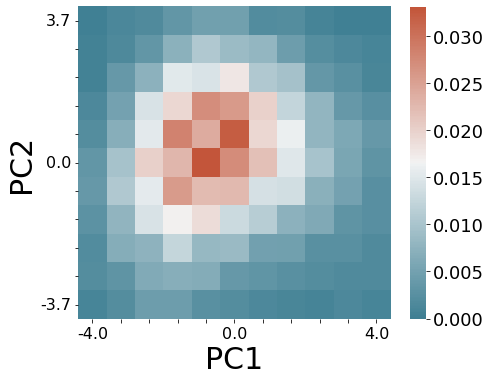

In [4]:
################ heatmap of probability density #############
#calculate the total time observed during the experiment
ttot = transdf.time_elapsed.sum()

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.sum()/ttot

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC2', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC2_PC2 probability density heatmap.png', bbox_inches='tight')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


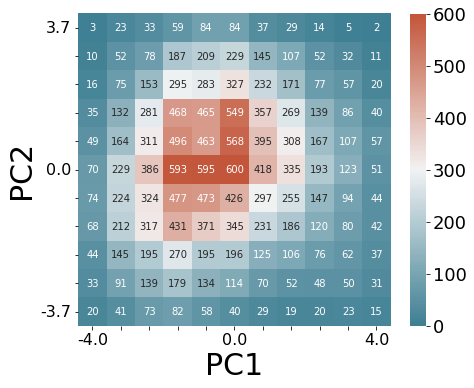

In [5]:
################ PLOT THE COUNTS OF THE BINS #############
#calculate the total time observed during the experiment
ttot = transdf.time_elapsed.sum()

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = len(current)

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.0f',
    ax = ax,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC2', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC2_PC2 transition count heatmap.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


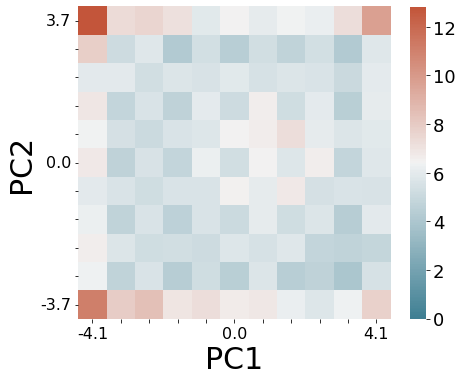

In [14]:
################ heatmap of AVERAGE DWELL TIME #############

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.mean()

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC2', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC2_PC2 avg dwell time heatmap.png', bbox_inches='tight')

In [ ]:
########## PC2/PC2 transition with error ellipses oriented to PCs ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0005

# combine fake error data with real transition data
elldf = bsframe.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})


meshdir = datadir + 'PC_Meshes/'

proj=[0,1]
PCkey = [1,2]
binkey = [1,5]      

fig = plt.figure(figsize=(10,10))

graphaxes, axes = PCvisualization.get_contours_for_axes(meshdir,
                proj,
                PCkey,
                binkey,
                )

    

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    graphaxes[0].axhline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # horizontal lines
    graphaxes[0].axvline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # vertical lines

#add contou line if desired
uple = [3,8]
lori = [8,4]
contourcoords = contour_coords(uple,lori)

#actually plot the contour
graphaxes[0].plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='black',alpha=0.3, zorder = 1 * 5)

    
    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        
        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(current.eval1)*(1/scale)*2,
                  height=np.sqrt(current.eval2)*(1/scale)*2,
                angle=np.arctan2(current.evec1y,current.evec1x))
        graphaxes[0].add_artist(ell)
        ell.set_alpha(0.2)
        ell.set_zorder(2 * 5)
#         print(np.sqrt(current.eval1), np.sqrt(current.eval2))

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        graphaxes[0].quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)),
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
graphaxes[0].set_xlabel('PC2', fontsize = 34)
graphaxes[0].set_ylabel('PC2', fontsize = 34)
graphaxes[0].set_xticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 18)
graphaxes[0].set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 18)
graphaxes[0].set_xlim(0,nbins+1)
graphaxes[0].set_ylim(0,nbins+1)

#legend background
lxp = 0.125
lyp = 10.25
rect = Rectangle((lxp, lyp), 1.625, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
graphaxes[0].add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
graphaxes[0].text(lxp+0.3,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
graphaxes[0].text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()



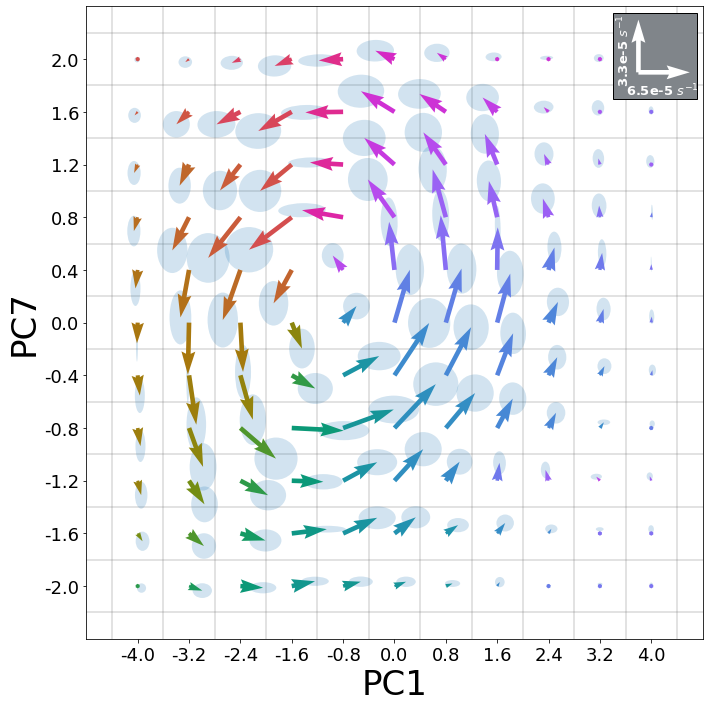

In [7]:
########## PC2/PC7 transition with error ellipses oriented to PCs WITHOUT PC MESH SLICES ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0008

# combine fake error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})



fig, ax = plt.subplots(figsize=(10,10))
    

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # vertical lines

    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1x.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                  height=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1y.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                angle=np.arctan2(current.evec1y,current.evec1x))
        ax.add_artist(ell)
        ell.set_alpha(0.2)

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        ax.quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)),
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
ax.set_xlabel('PC2', fontsize = 34)
ax.set_ylabel('PC7', fontsize = 34)
ax.set_xticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC2.to_list()], fontsize = 18)
ax.set_yticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC7.to_list()], fontsize = 18)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)

#legend background
lxp = 10.25
lyp = 10.25
rect = Rectangle((lxp, lyp), 1.645, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
ax.add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(centers.PC2.to_list()).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
ax.text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(centers.PC7.to_list()).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
ax.text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()

plt.savefig(savedir + 'PC2_PC7 Vector map absolute angle colored.png', bbox_inches='tight')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


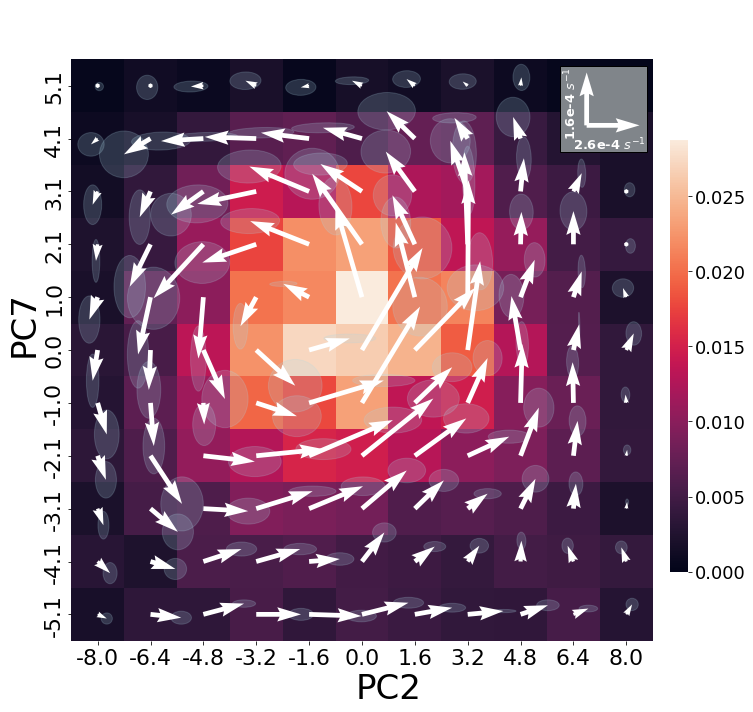

In [36]:
########## PC2/PC7 transition with error ellipses oriented to PCs WITHOUT PC MESH SLICES ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0008

# combine fake error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})



fig, ax = plt.subplots(figsize=(10,10))

cbar_ax = fig.add_axes([0.93, .2, .025, .6])


ttot = transdf.time_elapsed.sum()
#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.sum()/ttot
#plot heatmap with seaborn
sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap='rocket',
    square=True,
    xticklabels = True,
    yticklabels = True,
    ax = ax,
#     cbar=i==0,
    cbar_ax = cbar_ax,
#         cbar_kws=cbar_kws
)


    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

        ell = Ellipse(xy=(x-0.5+(xcurrent.values*(1/scale)),y-0.5+(ycurrent.values*(1/scale))),
                width=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1x.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                  height=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1y.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                angle=np.arctan2(current.evec1y,current.evec1x),
                     color = 'lightblue')
        ax.add_artist(ell)
        ell.set_alpha(0.2)

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        ax.quiver(x-0.5,
                   y-0.5, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = 'white',
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
ax.set_xlabel('PC2', fontsize = 34)
ax.set_ylabel('PC7', fontsize = 34)
ax.set_xticks(np.arange(0.5,nbins+0.5))
ax.set_xticklabels([round(x,1) for x in centers.PC2.to_list()], fontsize = 22)
ax.set_yticks(np.arange(0.5,nbins+0.5))
ax.set_yticklabels([round(x,1) for x in centers.PC7.to_list()], fontsize = 22)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)

#legend background
lxp = 9.25
lyp = 9.25
rect = Rectangle((lxp, lyp), 1.645, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
ax.add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(centers.PC2.to_list()).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
ax.text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(centers.PC7.to_list()).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
ax.text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()

plt.savefig(savedir + 'PC2_PC7 Vector map and pdf.png', bbox_inches='tight')

In [38]:
bsframe_sep_full

,x,y,x_minus_count,x_minus_count_rev,x_minus_for_rate,x_minus_rev_rate,x_minus_rate,x_plus_count,x_plus_count_rev,x_plus_for_rate,...,y_minus_count,y_minus_count_rev,y_minus_for_rate,y_minus_rev_rate,y_minus_rate,y_plus_count,y_plus_count_rev,y_plus_for_rate,y_plus_rev_rate,y_plus_rate
0,1,1,0,0,0.000000,0.000000,0.000000,0,0,0.000000,...,0,0,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000
1,1,2,0,0,0.000000,0.000000,0.000000,0,0,0.000000,...,0,0,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000
2,1,3,0,0,0.000000,0.000000,0.000000,0,0,0.000000,...,0,0,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000
3,1,4,0,0,0.000000,0.000000,0.000000,0,0,0.000000,...,0,0,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000
4,1,5,0,0,0.000000,0.000000,0.000000,1,0,0.000555,...,0,0,0.000000,0.000000,0.000000,0,1,0.000000,0.000555,-0.000555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,11,7,1,1,0.000554,0.000554,0.000000,0,0,0.000000,...,1,2,0.000554,0.001107,-0.000554,3,2,0.001661,0.001107,0.000554
117,11,8,0,0,0.000000,0.000000,0.000000,0,0,0.000000,...,2,3,0.001107,0.001661,-0.000554,1,0,0.000554,0.000000,0.000554
118,11,9,0,0,0.000000,0.000000,0.000000,0,0,0.000000,...,0,1,0.000000,0.000554,-0.000554,1,0,0.000554,0.000000,0.000554
119,11,10,1,0,0.000554,0.000000,0.000554,0,0,0.000000,...,0,1,0.000000,0.000554,-0.000554,0,0,0.000000,0.000000,0.000000


In [9]:
############## bootstrapped AERs #################
from CustomFunctions.DetailedBalance import get_area_enclosing_rate

if os.path.exists(savedir+f'PC2-PC7_Area_Enclosing_Rates.csv'):
    allaers = pd.read_csv(savedir+f'PC2-PC7_Area_Enclosing_Rates.csv', index_col=0)
else:
    start = 0
    stop = 200
    allresults = []

    while start<bsframe_sep_full.bs_iteration.max():
        print(f'Finished {start}, starting {start}-{stop}')
        if __name__ ==  '__main__':
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(start,stop+1):
                b = bsframe_sep_full[bsframe_sep_full.bs_iteration==x]
                pool.apply_async(get_area_enclosing_rate, args = (
                    b,
                    [5,6],
                    ),
                    callback = collect_results)
            pool.close()
            pool.join()

            allresults.extend(results)

            start = stop + 1
            stop = stop + 200
            if stop>bsframe_sep_full.bs_iteration.max():
                stop = bsframe_sep_full.bs_iteration.max()

        migboot = pd.DataFrame()
        migboot['aer'] = [a.aer.sum() for a in allresults]

    migboot = migboot.reset_index(drop=True)
    migboot.to_csv(savedir+'PC2-PC7_Area_Enclosing_Rates.csv')

In [17]:
p_value

0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-46.34559840637278 0.0


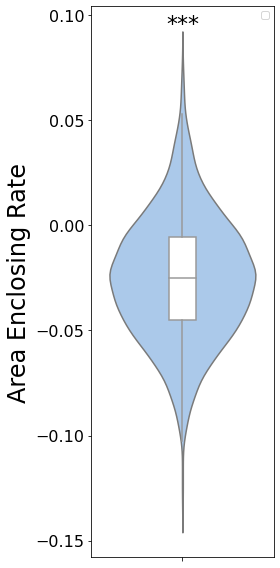

In [21]:
import scipy.stats as stats
t_statistic, p_value = stats.ttest_1samp(a=allaers.aer, popmean=0) 
print(t_statistic , p_value)
################ histograms of the contour integral distributions ###########

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=allaers, y = 'aer',
               palette = colorlist, inner = None, ax=ax)
sns.boxplot(data=allaers,y='aer', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax)

#labelste
ax.set_ylabel('Area Enclosing Rate', fontsize=24)#, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=16)
ax.set_xticklabels([''], fontsize = 14)
ax.text(0,0.093,'***',fontdict= {'fontsize': 22,
                               'horizontalalignment':'center'})


plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'alldata aer.png', bbox_inches='tight', dpi = 500)


In [20]:
######### do contour integrals ################
from CustomFunctions.DetailedBalance import contour_integral

uple = [3,8]
lori = [8,3]
if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}.csv'):
    omegas = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}.csv', index_col=0)
else:
    omegas = []
    for b in bslist:
        omegas.append(contour_integral(b, uple, lori, norm = False))
    omegas = pd.DataFrame(list(zip(omegas/pd.Series(omegas).std(),['omega']*len(omegas))), columns=['Norm_Omegas','sample'])
    omegas.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv')

In [14]:
################ histograms of the contour integral distributions ###########


colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=omegas, y = 'Norm_Omegas',
               palette = colorlist, inner = None, ax=ax)
sns.boxplot(data=omegas,y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=30, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels([''], fontsize = 14)



plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori}.png', bbox_inches='tight', dpi = 500)


NameError: name 'data' is not defined

In [22]:
######### do NORMALIZED contour integrals ################
from CustomFunctions.DetailedBalance import contour_integral

uple = [3,8]
lori = [8,4]
if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv'):
    omegas_norm = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv', index_col=0)
else:
    omegas = []
    for b in bslist:
        omegas.append(contour_integral(b, uple, lori, norm = True))
    omegas_norm = pd.DataFrame(list(zip(omegas/pd.Series(omegas).std(),['omega']*len(omegas))), columns=['Norm_Omegas','sample'])
    omegas_norm.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv')

(210.32165930822035, 0.0)


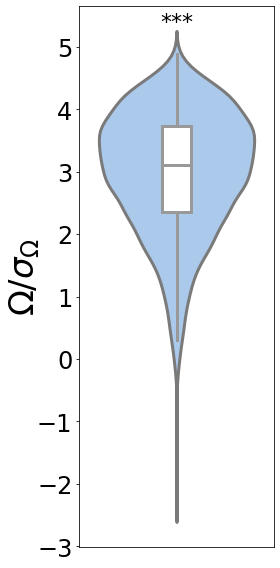

In [38]:
################ histograms of the contour integral distributions ###########
from statsmodels.stats.weightstats import ztest as ztest
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=omegas_norm, y = 'Norm_Omegas',
               palette = colorlist, linewidth = 3, inner = None, ax=ax)
sns.boxplot(data=omegas_norm,y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, linewidth = 3, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=34, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=24)
ax.set_xticklabels([''], fontsize = 14)
ax.set_xticks([])

ax.text(0,5.3,'***',fontdict= {'fontsize': 22,
                               'horizontalalignment':'center'})
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori} normalized.png', bbox_inches='tight', dpi = 500)
print(str(ztest(omegas_norm.Norm_Omegas, value=0)))

In [ ]:
################## how are the PC bins changing over time #########################
difflist = []
for i, d in TotalFrame[['CellID','Migration_Mode','frame','PC2bins','PC2bins','PC3bins','PC4bins']].sort_values(by='frame').groupby('CellID'):
    dtemp = d[['frame','PC2bins','PC2bins','PC3bins','PC4bins']].diff()
    dtemp = dtemp[dtemp.frame==1]
    dtemp['frame'] = d.frame[dtemp.index]
    dtemp['CellID'] =  [i]*len(dtemp)
    dtemp['Migration_Mode'] = d.Migration_Mode[dtemp.index]
    difflist.append(dtemp)
diffdf = pd.concat(difflist)

fig, axes = plt.subplots(4, 1, figsize=(20,40), sharey=True)
for a, ax in enumerate(axes):
    cpc = [x for x in diffdf.columns.to_list() if 'PC' in x][a]
    sns.boxplot(data=diffdf, x='frame', hue='Migration_Mode',y=cpc, ax=ax)
    ax.set_xticklabels(
        np.sort(diffdf.frame.unique()).astype(int),
        rotation=-45,
        fontsize = 12
        )
    #set axis titles
    ax.set_ylabel(cpc, fontsize = 30)
    ax.set_xlabel('Frame', fontsize = 22)
plt.tight_layout()
fig.savefig(savedir+'PC bin differentials.png', facecolor='white')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in 

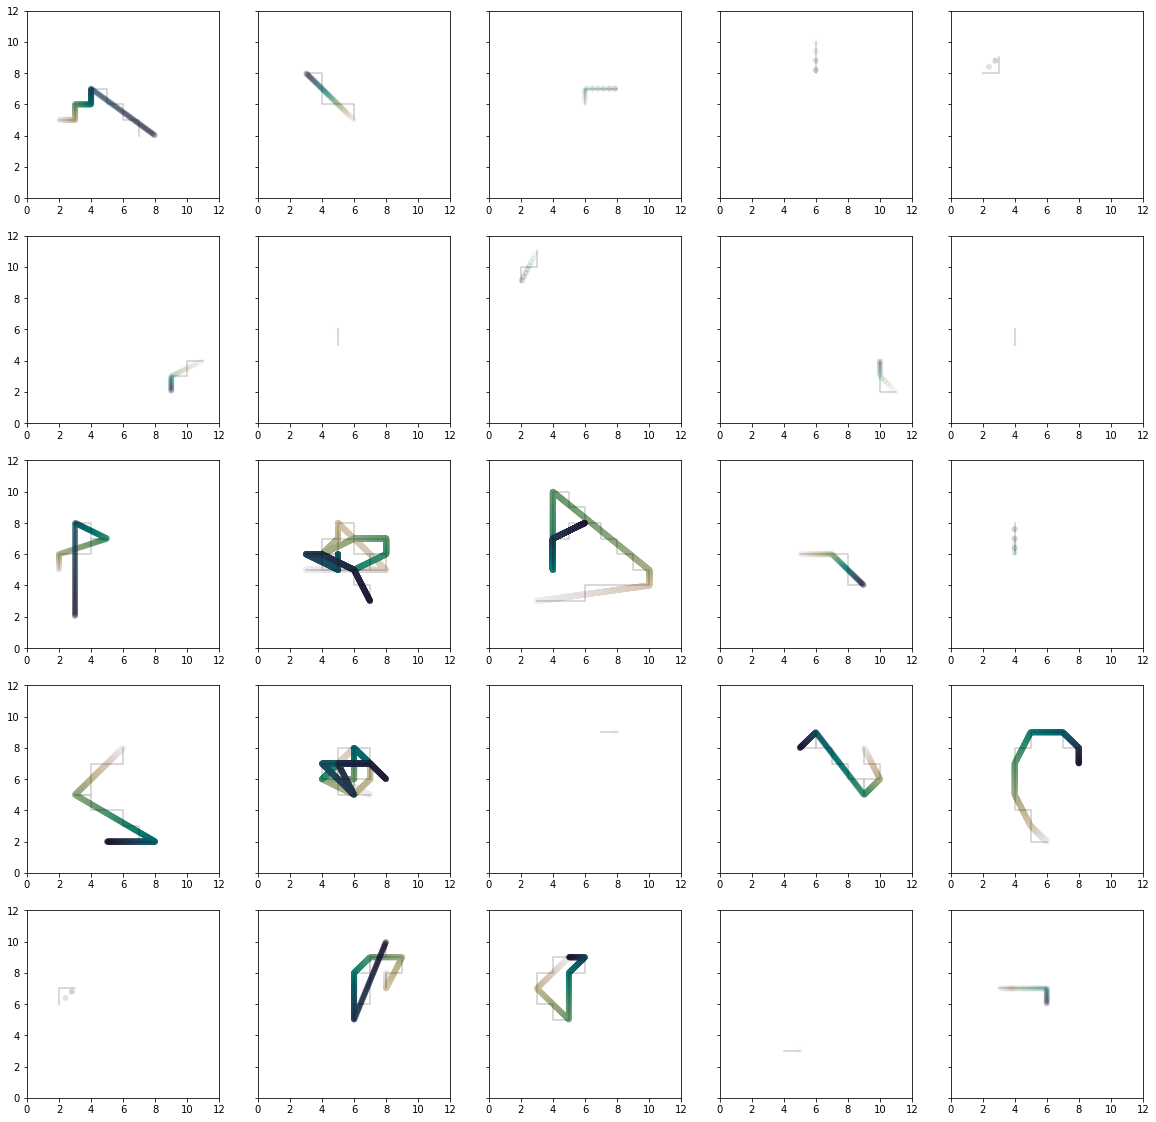

In [45]:
############# grid of plots of individual cells' INTERPOLATED transitions ###################

########### '20230509_488EGFP-CAAX_640SPY650-DNA2_cell_5' performs the exact loop #############

#the square root of plot number
pnum = 5
#randomly choose cells
sample = random.sample(list(transdf.CellID.unique()), pnum**2)

from cmocean import cm
norm = matplotlib.colors.Normalize()
cmm = cm.rain



fig, axes = plt.subplots(pnum,pnum,figsize=(20,20), sharey=True)
s = 0
#make numpy array with heatmap data
for x in range(pnum):
    for y in range(pnum):
        axes[x,y].set_xlim(0,nbins+1)
        axes[x,y].set_ylim(0,nbins+1)
        #get the next cell in the sample
        temp = transdf[transdf.CellID == sample[s]].reset_index(drop=True)
        #if temp is only 1 transition resample
        if len(temp)<2:
            temp = transdf[transdf.CellID == random.sample(list(transdf.CellID.unique()), 1)].reset_index(drop=True)
        #only get continuous frames 
        frames = temp[temp.frame.diff()>1].index.values
        if frames.size>0:
            if temp.index.values[0] != frames[0]:
                frames = np.append(temp.index.values[0], frames)
            if temp.index.values[-1] != frames[-1]:
                frames = np.append(frames, temp.index.values[-1])
            st = random.randrange(len(frames)-1)
            temp = temp.loc[frames[st]:frames[st+1]-1]
#             print(temp)
#         if s == len(sample)-1:
#             temp = alltrans.copy()
#             print(x,y)

        
        #get values of actual transitions based on the interpolated transitions
        fli = temp.frame.to_list()+[temp.frame.to_list()[-1]+1]
        acttemp = TotalFrame[(TotalFrame.CellID==temp.CellID.values[0])&(TotalFrame.frame.isin(fli))].sort_values(by='frame').reset_index(drop=True)
        #interpolate along the trajectory so I can plot dots which will represent the color gradient line
        px = acttemp.PC2bins.to_numpy()
        py = acttemp.PC2bins.to_numpy()
        pz = acttemp.frame.to_numpy()
        dist = np.nansum(scipy.spatial.distance.pdist(temp[['from_x','from_y']]))
        fx = scipy.interpolate.interp1d(np.arange(1,len(px)+1),px)
        newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
        fy = scipy.interpolate.interp1d(np.arange(1,len(py)+1),py)
        newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
        newz = np.arange(0,len(temp), len(temp)/len(newy))
        if len(newz)>len(newy):
            newz = newz[:-1]
        #normalize to the colors to the length of the trajectory
        norm.autoscale([0,newz.max()])
        #plot the actual transitions
        axes[x,y].scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.2, edgecolors='none')
        
        #plot the interpolated transitions
        ix = np.append(temp.from_x.to_numpy(), temp.to_x.to_numpy()[-1])
        iy = np.append(temp.from_y.to_numpy(), temp.to_y.to_numpy()[-1])
        axes[x,y].plot(ix, iy, color ='black', alpha=0.2)
        
        #add one to the sample count
        s = s+1

In [4]:
############### get shcoeffs for different positions around a particular 2d contour #############
from CustomFunctions.PCvisualization import interpolate_contour_shapes
import pickle as pk
from scipy import interpolate
from scipy.spatial import distance
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and '_' not in x]].mean().to_numpy()

pca = pk.load(open('/'.join(savedir.split('/')[:-2])+"/pca.pkl",'rb'))

PC2bins = centers.PC2.to_numpy()
PC2bins = centers.PC2.to_numpy()

whichpcs = [1,2]
lmax = 10
metrics = ['speed']
vertices = np.array([[8,8],
                    [8,3],
                    [3,3],
                    [3,8]])

contour_positions, loopname, metricsarray = interpolate_contour_shapes(vertices,
                               avgpcs,
                               whichpcs,
                               pca,
                               PC2bins,
                               PC2bins,
                               savedir,
                               lmax,
                               TotalFrame,
                               metrics)



In [10]:
pd.DataFrame(metricsarray)

,arbitrarytime,PC1bin,PC2bin,speed
0,0.000,8.0,8.0,0.071839
1,0.005,8.0,7.9,0.071839
2,0.010,8.0,7.8,0.071839
3,0.015,8.0,7.7,0.071839
4,0.020,8.0,7.6,0.071839
...,...,...,...,...
195,0.975,7.5,8.0,0.071839
196,0.980,7.6,8.0,0.071839
197,0.985,7.7,8.0,0.071839
198,0.990,7.8,8.0,0.071839


In [ ]:
########## animate a contour loop graph
from matplotlib.animation import FuncAnimation 

scale = 0.0005

#make fig
fig, ax = plt.subplots(figsize = (10,10))

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

    

for x in range(nbins):
    for y in range(nbins):
        current = trans_rate_df[(trans_rate_df['x'] == x+1) & (trans_rate_df['y'] == y+1)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
#             print(anglecolor)
        ax.quiver((x+1),
                   (y+1), 
                   xcurrent, 
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = 'black',
                 alpha = 0.2)    
    
    

ax.set_aspect("equal")
ax.set_xlabel('PC2', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


# create a point in the axes
point, = ax.plot(contour_positions[0,1],contour_positions[0,2], marker="o", color = '#eb4034', markersize = 15)

# make function for updating point position
def animate(i, contour_positions):
    point.set_data([contour_positions[i,1]], [contour_positions[i,2]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(contour_positions))), fargs = (contour_positions,))
# plt.show()

ani.save(savedir + 'contours/' + loopname + f'/{loopname}_plotanimation_PC2-PC2.mp4', fps=30, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


In [4]:
############## get the actual bin position reconstructions for still images ##########

from CustomFunctions.PCvisualization import mesh_from_bins
import pickle as pk

avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and 'dist' not in x]].mean().to_numpy()

pca = pk.load(open(datadir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10



specific_positions = np.array([
[3,8],
[5.5,8],
[8,8],
[8,6],
[8,4],
[5.5,4],
[3,4],
[3,6]])



for x in specific_positions:
    specificdir = savedir + str(x) + '.vtp'
    mesh_from_bins(x,
                   whichpcs,
                   avgpcs,
                   PC2bins,
                   PC2bins,
                   pca,
                   specificdir,
                   lmax,
                   )
